In [1]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [2]:
qibo.set_backend("tensorflow")
vqe_backend = construct_backend(backend="tensorflow")

[Qibo 0.2.12|INFO|2025-01-10 15:36:54]: Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2025-01-10 15:36:54]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


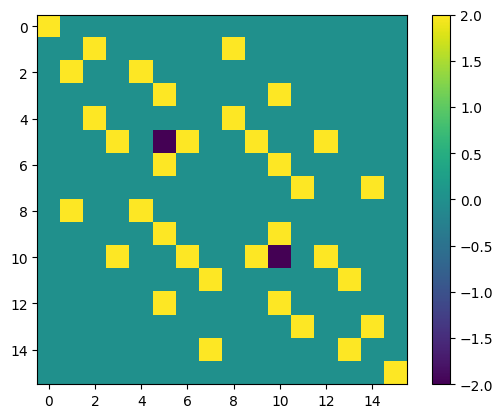

In [3]:
nqubits = 8
nqubits_half = int(nqubits/2)
delta = 0.5
ham_half = hamiltonians.XXZ(nqubits_half, delta, dense=False)
plt.imshow(np.real(ham_half.matrix))
plt.colorbar()

In [4]:
from boostvqe import ansatze
from copy import deepcopy
from functools import partial
from boostvqe.training_utils import vqe_loss
from boostvqe.utils import *

/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

In [ ]:
optimizer = 'sgd'
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits_half}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
with open(vqe_circ_file, 'r') as file:
    vqe_string = file.read()
vqe_circ_half = models.Circuit.from_qasm(vqe_string)

In [9]:
# target energy and vqe energy
zero_state = ham_half.backend.zero_state(nqubits)
target_energy = np.real(np.min(np.asarray(ham_half.eigenvalues())))
print('Target enegry:', target_energy)
print('VQE energy:',exact_expectation_boost(ham_half, vqe_circ_half).numpy())

Target enegry: -6.744562646538029
VQE energy: -6.309812021233838


In [10]:
print(vqe_circ_half.draw())

[Qibo 0.2.12|WARNING|2025-01-10 15:38:14]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───Z─RY─


In [12]:
c = Circuit(nqubits)
c.add(vqe_circ_half.on_qubits(*range(0,nqubits_half)))
c.add(vqe_circ_half.on_qubits(*range(nqubits_half, nqubits)))
print(c.draw())

[Qibo 0.2.12|WARNING|2025-01-10 15:38:48]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─────────────────────
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─────────────────────
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─────────────────────
q3: ─RY─RZ───Z─RY─RZ───Z─RY─────────────────────
q4: ─────────────────────RY─RZ─o───RY─RZ───o─RY─
q5: ─────────────────────RY─RZ─Z───RY─RZ─o─|─RY─
q6: ─────────────────────RY─RZ───o─RY─RZ─Z─|─RY─
q7: ─────────────────────RY─RZ───Z─RY─RZ───Z─RY─


In [16]:
full_ham = hamiltonians.XXZ(nqubits, delta, dense=False)
print(exact_expectation_boost(full_ham, c))

tf.Tensor(-9.46391959503744, shape=(), dtype=float64)


In [17]:
# steps (int): Number of time steps (default 1).
# order (int): the order of product formula, as of now, it takes value 1 or 2.
base_oracle = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=0.5, steps=1, order=1
)
# the following circuit performs exp{-0.01iH}
base_circ = base_oracle.circuit(t_duration=0.01)
print(base_circ.draw())

[Qibo 0.2.12|WARNING|2025-01-10 15:41:00]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0:     ────X───────RZ─o──────────X───────RZ─RZ───────o─RY───────X─RY───────o─ ...
q1:     ─RZ─o───────RY─X───────RY─o─────────────X─────|─RZ─o─────|────X─────|─ ...
q2:     ──────X─────RZ───o──────────X─────RZ─RZ─o─────|─RY─X─────|─RY─o─────|─ ...
q3:     ─RZ───o─────RY───X─────RY───o─────────────X───|─RZ───o───|──────X───|─ ...
q4:     ────────X───RZ─────o──────────X───RZ─RZ───o───|─RY───X───|─RY───o───|─ ...
q5:     ─RZ─────o───RY─────X───RY─────o─────────────X─|─RZ─────o─|────────X─|─ ...
q6:     ──────────X─RZ───────o──────────X─RZ─RZ─────o─|─RY─────X─|─RY─────o─|─ ...
q7:     ─RZ───────o─RY───────X─RY───────o─────────────X─RZ───────o──────────X─ ...

q0: ... ───
q1: ... RZ─
q2: ... ───
q3: ... RZ─
q4: ... ───
q5: ... RZ─
q6: ... ───
q7: ... RZ─


In [18]:
frame_oracle = FrameShiftedEvolutionOracle.from_evolution_oracle(
    circuit_frame=c,
    base_evolution_oracle=base_oracle,
)

In [19]:
# db_rotation = DoubleBracketRotationType.group_commutator_third_order_reduced
dbr_type = DoubleBracketRotationType.group_commutator_reduced
gci = GroupCommutatorIterationWithEvolutionOracles(
        frame_oracle,
        dbr_type
    )

In [20]:
eo_d_type = MagneticFieldEvolutionOracle
print(
        f"The gci mode is {gci.mode} rotation with {eo_d_type.__name__} as the oracle.\n"
    )

The gci mode is DoubleBracketRotationType.group_commutator_reduced rotation with MagneticFieldEvolutionOracle as the oracle.



In [21]:
# GCI settings
steps = 1
optimization_method = "sgd"
gd_epochs = 20
opt_options = {'gd_epochs':gd_epochs, }

In [22]:
for gci_step_nmb in range(steps):
    logging.info(
        "\n################################################################################\n"
        + f"Optimizing GCI step {gci_step_nmb+1} with optimizer {optimization_method}"
        + "\n################################################################################\n"
    )
    it = time.time()
    if optimization_method == optimization_method:
        params = (
            [4 - np.sin(x / 3) for x in range(nqubits)]
            if eo_d_type == MagneticFieldEvolutionOracle
            else [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
        )
        mode, best_s, best_b, eo_d = select_recursion_step_gd_circuit(
            gci,
            mode=dbr_type,
            eo_d_type=eo_d_type,
            params=params,
            step_grid=np.linspace(1e-5, 2e-2, 30),
            lr_range=(1e-3, 1),
            nmb_gd_epochs=gd_epochs,
            threshold=1e-4,
            max_eval_gd=30,
        )

        opt_dict = {"sgd_extras": "To be defined"}

    else:
        if gci_step_nmb == 0:
            p0 = [0.01]
            if eo_d_type == MagneticFieldEvolutionOracle:
                p0.extend([4 - np.sin(x / 3) for x in range(nqubits)])
            elif eo_d_type == IsingNNEvolutionOracle:
                p0.extend(
                    [4 - np.sin(x / 3) for x in range(nqubits)] + nqubits * [1]
                )

        else:
            p0 = [best_s]
            p0.extend(best_b)
        optimized_params, opt_dict = optimize_D(
            params=p0,
            gci=gci,
            eo_d_type=eo_d_type,
            mode=dbr_type,
            method=optimization_method,
            **opt_options,
        )
        best_s = optimized_params[0]
        best_b = optimized_params[1:]
        eo_d = eo_d_type.load(best_b)

    step_data = dict(
        best_s=best_s,
        eo_d_name=eo_d.__class__.__name__,
        eo_d_params=eo_d.params,
    )
    logging.info(f"Total optimization time required: {time.time() - it} seconds")
    gci.mode_double_bracket_rotation = dbr_type

    gci(best_s, eo_d, dbr_type)


INFO:root:
################################################################################
Optimizing GCI step 1 with optimizer sgd
################################################################################

INFO:root:Total optimization time required: 79.36590719223022 seconds


Just finished the selection: better loss -11.486130967811897 for mode DoubleBracketRotationType.group_commutator_reduced,                with duration s=0.02, and eo_d name = MagneticFieldEvolutionOracle


In [23]:
from qibo.quantum_info.metrics import fidelity

In [24]:
def report(vqe_circ, hamiltonian, gci, step, eo_d, mode):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_loss = float(gci.loss(step, eo_d, mode))
    gap = float(energies[1] - energies[0])

    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_loss=float(gci_loss),
            vqe_energy=float(vqe_energy),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_loss - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_loss - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_loss - ground_state_energy) / gap,
            fidelity_vqe=fidelity(vqe_circ().state(), hamiltonian.ground_state()),
            fidelity_gci=fidelity(
                gci.get_composed_circuit(best_s, eo_d, dbr_type)().state(), hamiltonian.ground_state()
            ),
        )
        | gci.get_gate_count_dict(gci.get_composed_circuit(best_s, eo_d, dbr_type))
    )
    
def print_report(report: dict):
    print(
        f"\
    The target energy is {report['target_energy']}\n\
    The VQE energy is {report['vqe_energy']} \n\
    The DBQA energy is {report['gci_loss']}. \n\
    The difference is for VQE is {report['diff_vqe_target']} \n\
    and for the DBQA {report['diff_gci_target']} \n\
    which can be compared to the spectral gap {report['gap']}.\n\
    The relative difference is \n\
        - for VQE {report['diff_vqe_target_perc']}% \n\
        - for DBQA {report['diff_gci_target_perc']}%.\n\
    The energetic fidelity witness of the ground state is: \n\
        - for the VQE  {report['fidelity_witness_vqe']} \n\
        - for DBQA {report['fidelity_witness_gci']}\n\
    The true fidelity is \n\
        - for the VQE  {report['fidelity_vqe']}\n\
        - for DBQA {report['fidelity_gci']}\n\
                    "
    )
    print(
        f"The boosting circuit used {report['nmb_cnot']} CNOT gates coming from compiled XXZ evolution and {report['nmb_cz']} CZ gates from VQE.\n\
For {report['nqubits']} qubits this gives n_CNOT/n_qubits = {report['nmb_cnot_relative']} and n_CZ/n_qubits = {report['nmb_cz_relative']}"
    )

In [25]:
this_report = report(c, full_ham, gci, best_s, eo_d, dbr_type)
print_report(this_report)

[Qibo 0.2.12|WARNING|2025-01-10 15:44:46]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
/Users/pethidine/Library/Caches/pypoetry/virtualenvs/boostvqe-9Q-2T4PW-py3.11/lib/python3.11/site-packages/tensorflow/python/framework/ops.py:307: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


    The target energy is -12.347977420549542
    The VQE energy is -9.46391959503744 
    The DBQA energy is -11.132616433708831. 
    The difference is for VQE is 2.8840578255121017 
    and for the DBQA 1.215360986840711 
    which can be compared to the spectral gap 1.360059005679572.
    The relative difference is 
        - for VQE 23.356520078441704% 
        - for DBQA 9.842591587656319%.
    The energetic fidelity witness of the ground state is: 
        - for the VQE  -1.1205387512367837 
        - for DBQA 0.10639098615178155
    The true fidelity is 
        - for the VQE  0.5793512411562011
        - for DBQA 0.7997779320767341
                    
The boosting circuit used 96 CNOT gates coming from compiled XXZ evolution and 72 CZ gates from VQE.
For 8 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 12.0


In [26]:
composed_circ = gci.get_composed_circuit(best_s, eo_d, dbr_type)

In [27]:
vqe_c = models.Circuit.to_qasm(c)
gci_c = models.Circuit.to_qasm(composed_circ)

In [28]:
nlayer = 1
import os

In [29]:
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
os.makedirs(folder_path, exist_ok=True)
with open(folder_path + f"vqe_circ_step1_2vqe.qasm", "w") as file:
    file.write(vqe_c)

with open(folder_path + f"gci_circ_step1_2vqe.qasm", "w") as file:
    file.write(gci_c)